In [8]:
# Sameh Alaa Nazeh Younes       4211016    B2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, Bidirectional, concatenate

In [9]:
df = pd.read_csv('/kaggle/input/stock-market/Market.csv', usecols=['Open', 'Close', 'High', 'Low'])
df.dropna(inplace=True)

In [10]:
df.head()

,Open,High,Low,Close
0,528.690002,528.690002,528.690002,528.690002
1,527.210022,527.210022,527.210022,527.210022
2,527.840027,527.840027,527.840027,527.840027
3,531.119995,531.119995,531.119995,531.119995
4,532.070007,532.070007,532.070007,532.070007


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110247 entries, 0 to 112456
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    110247 non-null  float64
 1   High    110247 non-null  float64
 2   Low     110247 non-null  float64
 3   Close   110247 non-null  float64
dtypes: float64(4)
memory usage: 4.2 MB


In [12]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

In [13]:
def create_sequences(data, window_size):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 2])

    return np.array(X), np.array(y)

train_size = int(len(df) * 0.9)
validation_size = int(train_size * 0.05)
test_size = int(train_size * 0.05)

train_data = scaled_df[:train_size]
val_data = scaled_df[train_size:train_size + validation_size]
test_data = scaled_df[train_size + validation_size:train_size + validation_size + test_size]

window_size = 14

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [16]:
input_layer = Input(shape=(window_size, 4))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.2)(conv1)

conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.2)(conv2)

conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.3)(conv3)

flatten = Flatten()(conv3)

lstm = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
merged = concatenate([flatten, lstm])

dense1 = Dense(128, activation='relu')(merged)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dense1)
dropout = Dropout(0.2)(dense2)

output_layer = Dense(1, activation='linear')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 14, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 14, 64)         │            832 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 14, 64)         │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 14, 64)         │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 14, 128)        │         24,704 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 14, 128)        │            512 │ conv1d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 14, 128)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 14, 256)        │         98,560 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 14, 256)        │          1,024 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 14, 256)        │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3584)           │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         35,328 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3712)           │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │        475,264 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          8,256 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)  

 Total params: 644,801 (2.46 MB)

 Trainable params: 643,905 (2.46 MB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2444 - mae: 0.1656 - val_loss: 0.0040 - val_mae: 0.0496
Epoch 2/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0053 - mae: 0.0423 - val_loss: 0.0072 - val_mae: 0.0665
Epoch 3/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0042 - mae: 0.0365 - val_loss: 0.0149 - val_mae: 0.1132
Epoch 4/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 0.0026 - mae: 0.0283 - val_loss: 0.0024 - val_mae: 0.0418
Epoch 5/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 0.0022 - mae: 0.0260 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 6/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 0.0022 - mae: 0.0262 - val_loss: 2.0458e-04 - val_mae: 0.0116
Epoch 7/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.0019 - mae: 0.0245 - val_loss: 0.0030 - val_mae: 0.0461
Epoch 8/50
3101/3101 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0019 - mae: 0.0242 - val_loss: 0.0029 - val_mae: 0.0444
Epoch 9/50
3101/3101

In [18]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0528
Test Loss: 0.0021997159346938133, Test MAE: 0.0452711395919323


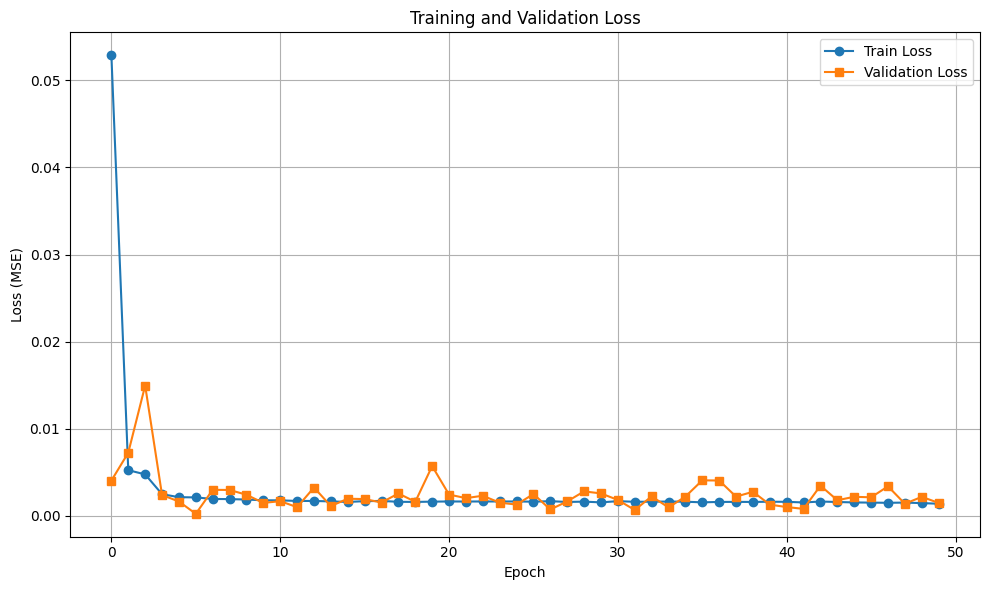

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

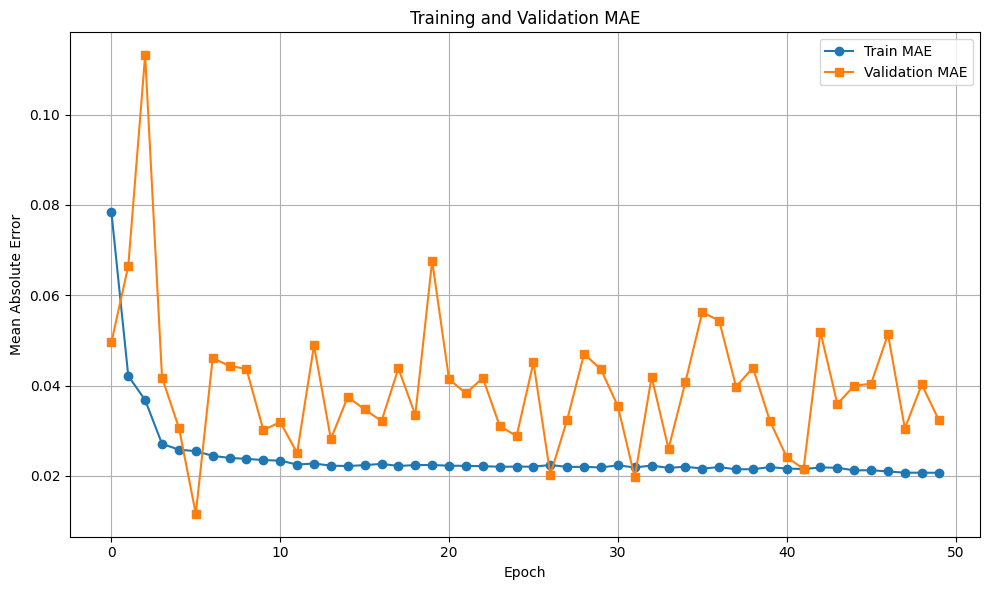

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='s')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()